In [1]:
using QuantumOptics
using WignerSymbols
using FFTW
using Plots
using LaTeXStrings
using Random
using Statistics
using LinearAlgebra
pyplot();

## Sub-Doppler cooling in a $\sigma^--\sigma^+$ molasses configuration (free space)
It turns out that if we use an atom with a more complicated electronic structe, we get sub-Doppler cooling through polarization gradients for free in this molasses configuration. It works for any $J \rightarrow J' = J + 1$ transition, with the $J = 1 \rightarrow J' = 2$ transition as the simplest case. If we denote the ground states by $|g_0\rangle, |g_{\pm 1}\rangle$ and the excited states by $|e_0\rangle, |e_{\pm 1}\rangle, |e_{\pm 2}\rangle$, the Hamiltonian is given by:
\begin{align}
    \mathcal{H} &= \frac{\Omega}{2} \Bigg[ e^{ikz} \left( |e_2\rangle\langle g_1| + \frac{1}{\sqrt{2}} |e_1\rangle\langle g_0| + \frac{1}{\sqrt{6}} |e_0\rangle\langle g_{-1}| \right) \\
                &\quad + e^{-ikz} \left( |e_{-2}\rangle\langle g_{-1}| + \frac{1}{\sqrt{2}} |e_{-1}\rangle\langle g_0| + \frac{1}{\sqrt{6}} |e_{-2}\rangle\langle g_{-1}| \right) \Bigg] + \mathrm{H.c.} \\
                &\quad -\delta \sum_e |e\rangle\langle e|
\end{align}
Here we can identify two running waves of opposite circular polarization traveling in opposite directions. They do not form any intensity gradient, but as Jean Dalibard and Claude Cohen-Tannoudji [have shown](https://www.osapublishing.org/josab/abstract.cfm?uri=josab-6-11-2023) it rather results in a corkscrew-like pattern of rotating linear polarization. The sum on the last line is understood to run over all excited states $|e\rangle$.

#### Units
In cooling calculations it's convenient to express all frequencies in units of $\Gamma$, the natural line width, and any distances in units of $1/k$, also known as $ƛ$. This means velocities are given in units of $\Gamma/k$. Furthermore, we have chosen atomic units (by setting $\hbar = 1$), which means forces are readily expressed in units of $\hbar k \Gamma$.

In [3]:
δ = -0.5;
Ω = 0.25;
s₀ = 2 * Ω^2;
s = 2*Ω^2 / (4*δ^2 + 1);

We need a basis that includes the three hyperfine ground states $|1, -1\rangle, |1, 0\rangle, |1, 1\rangle$ and the five hyperfine excited states: $|2, -2\rangle \cdots |2, 2\rangle$.
To this order we'll set up an 8-dimensional generic basis, where we'll stick in the couplings by hand. 

In [4]:
Fg = 1;
Fe = 2;
nStates = 2*(Fg + Fe) + 2;
gStates= [[Fg, mFg] for mFg in [-Fg:Fg;]];
eStates = [[Fe, mFe] for mFe in [-Fe:Fe;]];
states = [gStates; eStates];
sbasis = GenericBasis(nStates);

In [5]:
σmincoupling = [[[j+(2*Fg + 1) i 1. * clebschgordan(gStates[i][1], gStates[i][2], 1, -1, eStates[j][1], eStates[j][2] )] for i in [1:(2*Fg + 1);]] for j in [1:(2*Fe + 1);]];
σmincoupling = collect(Iterators.flatten(σmincoupling));
VminMat = vcat(σmincoupling...);
Vminhalf = Ω / 2 * SparseOperator(sbasis, complex(sparse(VminMat[:, 1], VminMat[:, 2], VminMat[:, 3], nStates, nStates)));
Vmintot(z) = exp(-im * z) * Vminhalf + dagger(exp(-im * z) * Vminhalf);

σpluscoupling = [[[j+(2*Fg + 1) i 1. * clebschgordan(gStates[i][1], gStates[i][2], 1, 1, eStates[j][1], eStates[j][2] )] for i in [1:(2*Fg + 1);]] for j in [1:(2*Fe + 1);]];
σpluscoupling = collect(Iterators.flatten(σpluscoupling));
VplusMat = vcat(σpluscoupling...);
Vplushalf = Ω / 2 * SparseOperator(sbasis, complex(sparse(VplusMat[:, 1], VplusMat[:, 2], VplusMat[:, 3], nStates, nStates)));
Vplustot(z) = exp(im * z) * Vplushalf + dagger(exp(im * z) * Vplushalf);

Define the Hamiltonian and force. The force is defined clasically as
$$
    F = -\langle \nabla\mathcal{H} \rangle.
$$

In [6]:
diagonalTerm = SparseOperator(sbasis, complex(Matrix(Diagonal([zeros(2*Fg + 1); ones(2*Fe + 1)]))));

In [7]:
H(z) = Vplustot(z) + Vmintot(z) - δ * diagonalTerm;
F(z) = -im * (-exp(-im * z) * Vminhalf + dagger(exp(-im * z) * Vminhalf) + exp(im * z) * Vplushalf - dagger(exp(im * z) * Vplushalf));

### Decay, dephasing, and jump operators
The full evolution of the density matrix $\rho$ is given by the master equation
$$
    \frac{d\rho}{dt} = -i\left[\mathcal{H}, \rho \right] + \sum_L L\rho L^\dagger - \frac{1}{2} \left\{ L^\dagger L, \rho \right\}.
$$
where $L$ are the quantum jump operators. Due to our choice of units, the values that enter in the matrices are simply the Clebsch-Gordan coefficients. The rate (which is specified separately) is unity. We don't really need to bother with this master equation itself, since QuantumOptics.jl will do it for us.

We obtain the quantum jump operators by iterating over all the possible couplings, and using those with nonzero Clebsch-Gordan coefficients. To that extent, we need the couplings by $\pi$ photons as well. Decay paths with the same polarization are combined into a single jump operator.

In [8]:
πcoupling = [[[j+(2*Fg + 1) i 1. * clebschgordan(gStates[i][1], gStates[i][2], 1, 0, eStates[j][1], eStates[j][2] )] for i in [1:(2*Fg + 1);]] for j in [1:(2*Fe + 1);]];
πcoupling = collect(Iterators.flatten(πcoupling));

L = [];

# Loop over all excited states, and find paths down
for couplings in (σmincoupling, σpluscoupling, πcoupling)
    cpls = vcat(couplings...);
    
    # Combine all decays with a particular polarization into one jump operator (select nonzero elements)
    cpls = cpls[ cpls[:, 3] .> 0., : ]
    
    # Construct the jump operator describing that decay
    L = vcat(L, SparseOperator(sbasis, sparse(cpls[:, 2], cpls[:, 1], complex(cpls[:, 3]), nStates, nStates)));
end

rate = ones(3);
Ldagger = dagger.(L);

Define the initial condition and the time axis; these are the last ingredients needed for solving the master equation. We define a function that returns the force for some specified velocity. The wave function needs to be evolved for long enough such that it reaches equilibrium. We have found that a time of $4\pi/v$ does the job (the slower the atom, the longer it takes to reach equilibrium).

In [9]:
function fquantum_master(t, ψ, u)
    z = u[1];
    H = Vplustot(z) + Vmintot(z) - δ * diagonalTerm;
    return H, L, Ldagger
end

fquantum_master (generic function with 1 method)

### The classical part
Below we define the classical part of the problem. `QuantumOptics.jl` encodes the classical variables in a vector `u`. We define the first component as the position, and the second component as the momentum. Above we already introduced the classical force due to the light fields, here we add the harmonic confinement to that. We need to take some care with units, though. We already defined the mass unit through $\hbar$, and the energy through $\hbar\Gamma$. Therefore, any force is in units of $\hbar k\Gamma$. This means that we cannot simply put masses in units of the mass of rubidium, and need to use the dimensionless mass:
$$
    \tilde{m} = \frac{m\Gamma}{\hbar k^2},
$$
which, for $^{87}$Rb is roughly 800. In dimensionless units, our equations of motion are:
\begin{align}
    \dot{x} &= p/m \\
    \dot{p} &= F.
\end{align}

In [1]:
dimlessmass = 796.89;

function fclassical(t, ψ, u, du)
    # u[1] = z
    # u[2] = p
    if isa(ψ, Ket)
        normFac = dagger(ψ) * ψ;
    elseif isa(ψ, DenseOperator)
        normFac = tr(ψ);
    end
    du[1] = u[2]/dimlessmass;
    du[2] = real(expect(F(u[1]), ψ)) / normFac;
    du[3] = 0.
    return nothing
end

function fjump_classical(t, ψ, u, i)
    p3D = rand(3) .- 0.5;
    normalize!(p3D);
    u[2] += p3D[1];
    u[3] += 1.;
    return nothing
end

fjump_classical (generic function with 1 method)

### Launch simulations
We can compare a master-equation evolution without recoil effects to a bunch of averaged Monte Carlo trajectories (inspired by [this example](https://docs.qojulia.org/examples/cavity-cooling/#Cavity-cooling-of-a-two-level-atom-1) from the QuantumOptics.jl documentation).

In [11]:
p0 = 20.;    # Initial momentum
x0 = 0.;     # Initial position

ψ₀ = Ket(sbasis, [1; 1; 1; zeros(nStates - 3)])/sqrt(3);
u0 = ComplexF64[x0, p0, 0.];
ρ_sc = semiclassical.State(ψ₀, u0);

fout = (t, psi) -> real(psi.classical[2]);

T = [0 : 0.1 : 10000;];
tout, p_mastereq = semiclassical.master_dynamic(T, ρ_sc, fquantum_master, fclassical; fout = fout);

In [103]:
Ntraj = 100;
Ωs = [0.1, 0.2, 0.3, 0.4, 0.5];

p_MCsq = [zeros(length(T)) for i in 1:length(Ωs)]
p_MC = [zeros(length(T)) for i in 1:length(Ωs)]

for j = 1:length(Ωs)
    Ω = Ωs[j]
    for i = 1:Ntraj
        t_, ρ = semiclassical.mcwf_dynamic(T, ρ_sc, fquantum_master, fclassical, fjump_classical); #; fout = fout);
        p_ = real.([ψ.classical[2] for ψ in ρ]);

        p_MC[j] += p_ / Ntraj;
        p_MCsq[j] += p_.^2 / Ntraj;
        if i % 10 == 0
            print(Ω, "\t", i, "\n");
        end
    end
    IJulia.clear_output()
end

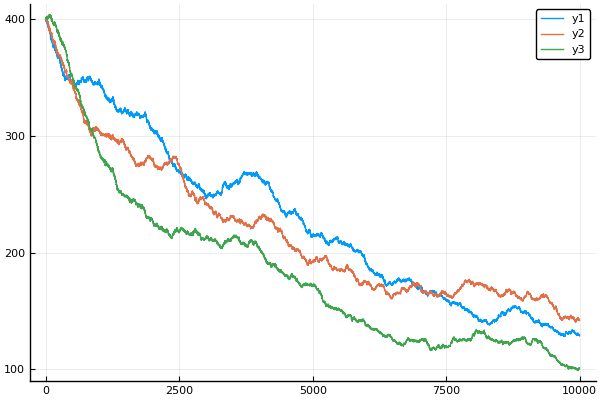

In [104]:
plot(T, p_MCsq[1])
plot!(T, p_MCsq[2])
plot!(T, p_MCsq[3])
#plot!(T, p_mastereq.^2)
#plot!(T, jumpindex)